<a href="https://colab.research.google.com/github/Yomunozs/Aprendizaje_Maquina/blob/main/4_Clasificacion_Clustering_DR/pruebapeopleclasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](http://vis-www.cs.umass.edu/lfw/)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [ ]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        if normalize:
            title = 'Matriz de confusión normalizada'
        else:
            title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


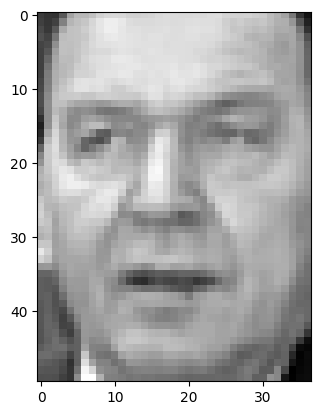

In [ ]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [ ]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion/grid_search_cross_validation.png?raw=1)

In [ ]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [ ]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento más alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]


0.43286065070595453

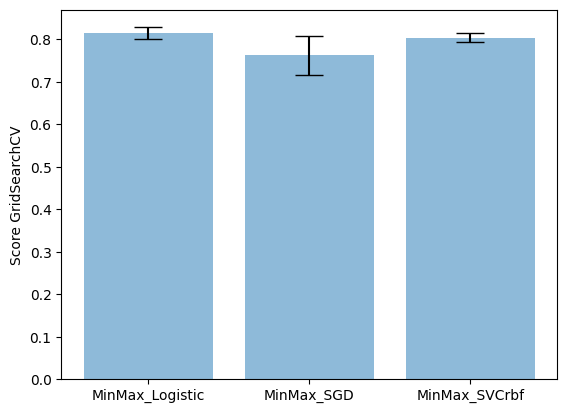

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.815 0.762 0.804]
 [0.014 0.046 0.011]]


In [ ]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://androidkt.com/micro-macro-averages-for-imbalance-multiclass-classification/).

Evaluando modelo MinMax_Logistic (1/3)


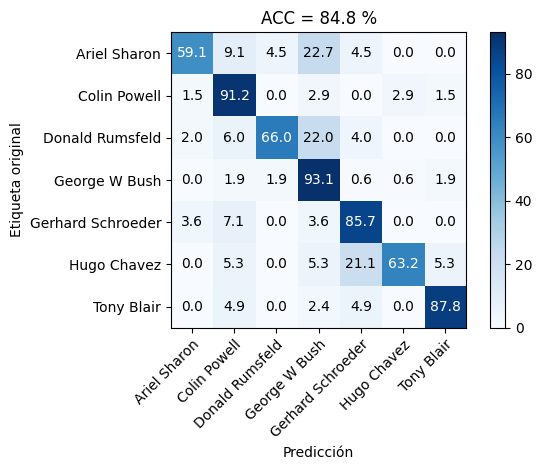

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/3)


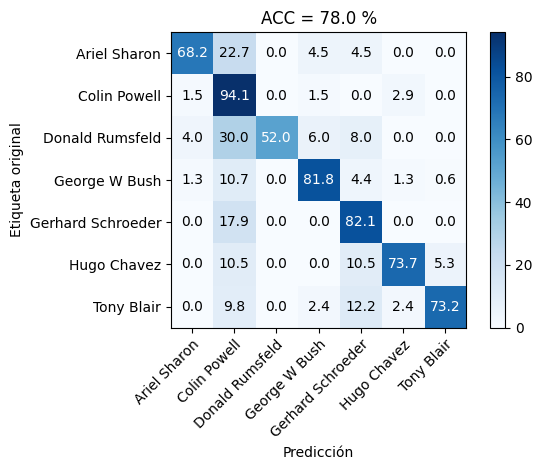

                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.68      0.71        22
     Colin Powell       0.57      0.94      0.71        68
  Donald Rumsfeld       1.00      0.52      0.68        50
    George W Bush       0.96      0.82      0.88       159
Gerhard Schroeder       0.55      0.82      0.66        28
      Hugo Chavez       0.74      0.74      0.74        19
       Tony Blair       0.94      0.73      0.82        41

         accuracy                           0.78       387
        macro avg       0.79      0.75      0.74       387
     weighted avg       0.84      0.78      0.79       387

Evaluando modelo MinMax_SVCrbf (3/3)


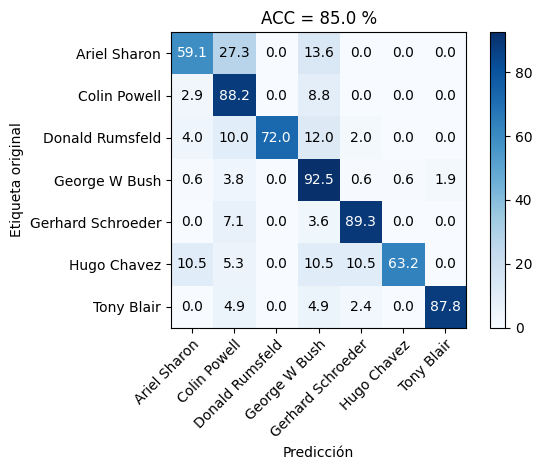

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387



In [ ]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          normalize=True,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

Evaluando modelo MinMax_Logistic (1/3)


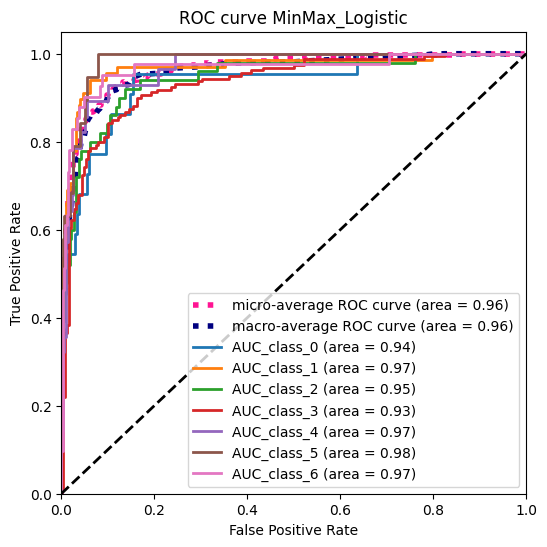

Evaluando modelo MinMax_SGD (2/3)


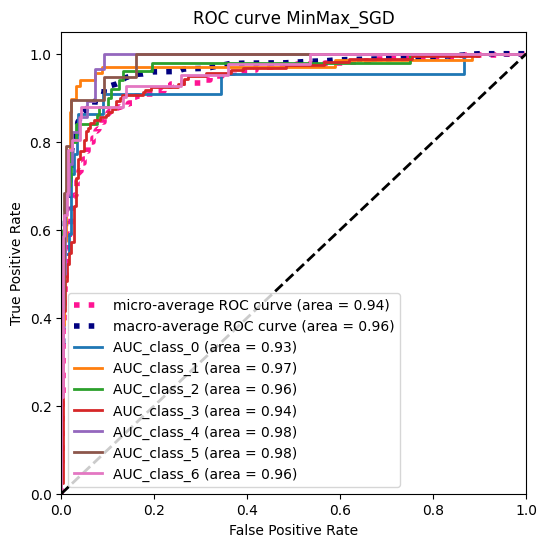

Evaluando modelo MinMax_SVCrbf (3/3)


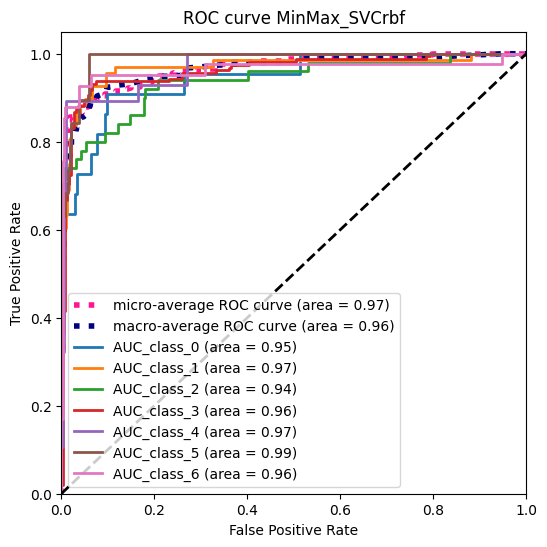

In [ ]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    ytest_score = my_model_loaded[i].decision_function(Xtest)
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)


# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)



In [ ]:
##############################################################################################################################################################


2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1 en términos de validación cruzada con gridserachCV y en el conjunto de test (30% de los datos originales), fijando el score del gridsearch en términos del acc y el f1. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 1.

In [ ]:
!pip install scikit-learn # install scikit-learn if it's not already installed
from sklearn.naive_bayes import GaussianNB # import the GaussianNB class
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier




#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', GaussianNB())], #Pipeline 1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline 2
        [('nor', MinMaxScaler()),
         ('cla', LogisticRegression())], #Pipeline 3
       [('nor', MinMaxScaler()),
        ('cla', LinearDiscriminantAnalysis())], #Pipeline 4
       [('nor',  MinMaxScaler()),
        ('cla', KNeighborsClassifier())],#Pipeline 5
        [('nor',MinMaxScaler()),
         ('cla', LinearSVC())],# Pipeline 6
       [('nor',  MinMaxScaler()),
        ('cla', SVC())],#Pipeline 7
        [('nor',MinMaxScaler()),
         ('cla', RandomForestClassifier())]#Pipeline 8
      ]
# Teniendo en cuenta la consulta realizada en el punto 1, se asignan valores diferentes a los parametros que maneja cada problema de optimización
parameters = [{
              'cla__var_smoothing': [1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline 1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline 2 - hyperparametros
              'cla__loss': ['hinge', 'log', 'modified_huber'],
              'cla__penalty': ['l1', 'l2', 'elasticnet']
              },
              {
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline 3 - hyperparametros
              },
              {
              'cla__solver': ['svd', 'lsqr', 'eigen'],#Pipeline 4 - hyperparametros
              },
              {
              'cla__n_neighbors': [3,5,7,9,11,13,15,17,19,21],#Pipeline 5 - hyperparametros
              'cla__weights': ['uniform', 'distance'],
              'cla__metric': ['euclidean', 'manhattan', 'minkowski']
              },
              {
              'cla__C': [1,10,1e2,1e3,1e4],#Pipeline 6 - hyperparametros
              'cla__loss': ['hinge', 'squared_hinge'],
              'cla__penalty': ['l1', 'l2']
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline 7 - hyperparametros
             },
              {
              'cla__n_estimators': [20,50], #Pipeline 8 - hyperparametros
              'cla__criterion': ['gini', 'entropy'],
              'cla__max_depth': [3,5,7,9,11],
              'cla__min_samples_split': [2,4,6],
              'cla__min_samples_leaf': [1,3,5]
              }
             ]



models_acc = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models_acc += [grid_search] #guardar modelos
    #joblib.dump(models_acc,filename+".pkl")

modelo 1/8
Fitting 5 folds for each of 13 candidates, totalling 65 fits
modelo 2/8
Fitting 5 folds for each of 63 candidates, totalling 315 fits
modelo 3/8
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 4/8
Fitting 5 folds for each of 3 candidates, totalling 15 fits
modelo 5/8
Fitting 5 folds for each of 60 candidates, totalling 300 fits
modelo 6/8
Fitting 5 folds for each of 20 candidates, totalling 100 fits
modelo 7/8
Fitting 5 folds for each of 25 candidates, totalling 125 fits
modelo 8/8
Fitting 5 folds for each of 180 candidates, totalling 900 fits


Evaluating model MinMax_Logistic (1/8)


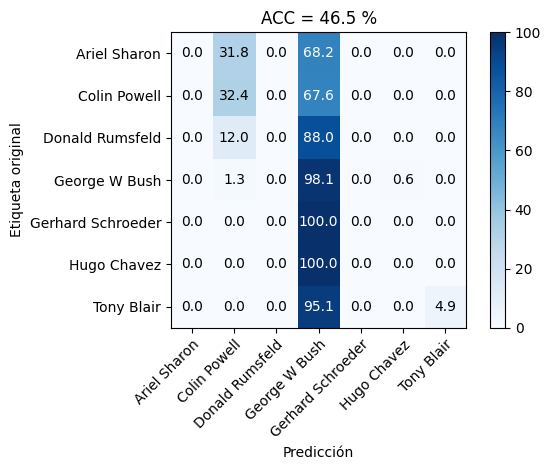

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        22
     Colin Powell       0.59      0.32      0.42        68
  Donald Rumsfeld       0.00      0.00      0.00        50
    George W Bush       0.45      0.98      0.62       159
Gerhard Schroeder       0.00      0.00      0.00        28
      Hugo Chavez       0.00      0.00      0.00        19
       Tony Blair       1.00      0.05      0.09        41

         accuracy                           0.47       387
        macro avg       0.29      0.19      0.16       387
     weighted avg       0.40      0.47      0.34       387

Evaluating model MinMax_SGD (2/8)


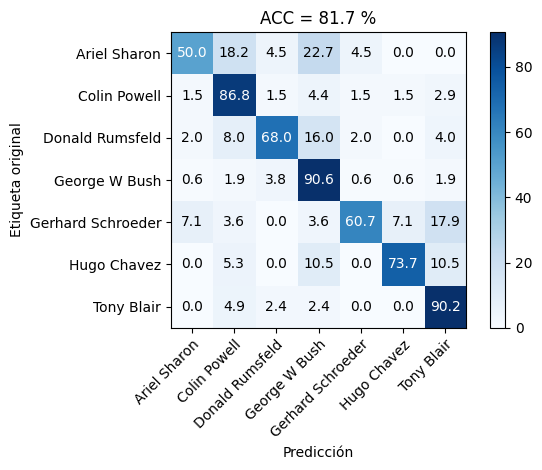

                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.50      0.58        22
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.79      0.68      0.73        50
    George W Bush       0.88      0.91      0.89       159
Gerhard Schroeder       0.81      0.61      0.69        28
      Hugo Chavez       0.78      0.74      0.76        19
       Tony Blair       0.73      0.90      0.80        41

         accuracy                           0.82       387
        macro avg       0.78      0.74      0.76       387
     weighted avg       0.82      0.82      0.81       387

Evaluating model MinMax_SVCrbf (3/8)


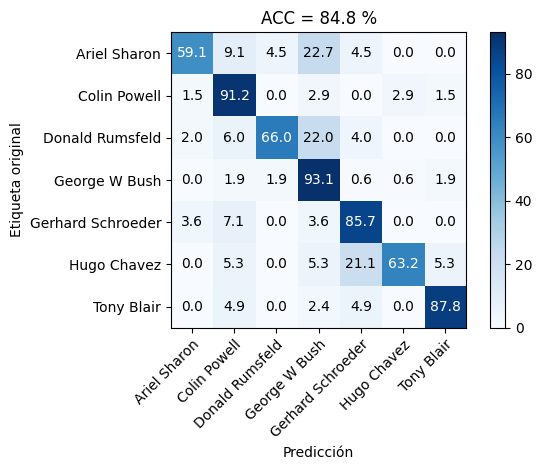

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluating model 4/8


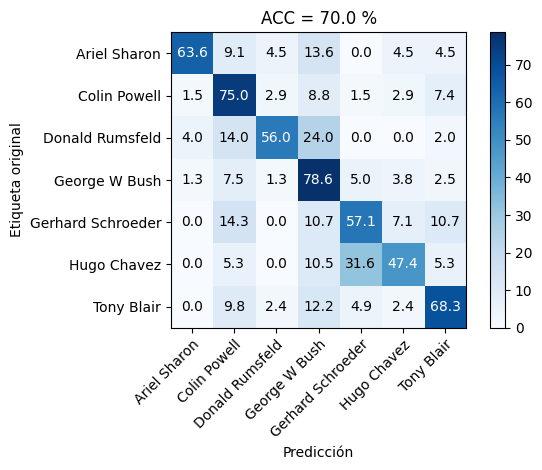

                   precision    recall  f1-score   support

     Ariel Sharon       0.74      0.64      0.68        22
     Colin Powell       0.63      0.75      0.68        68
  Donald Rumsfeld       0.82      0.56      0.67        50
    George W Bush       0.80      0.79      0.79       159
Gerhard Schroeder       0.48      0.57      0.52        28
      Hugo Chavez       0.43      0.47      0.45        19
       Tony Blair       0.65      0.68      0.67        41

         accuracy                           0.70       387
        macro avg       0.65      0.64      0.64       387
     weighted avg       0.71      0.70      0.70       387

Evaluating model 5/8


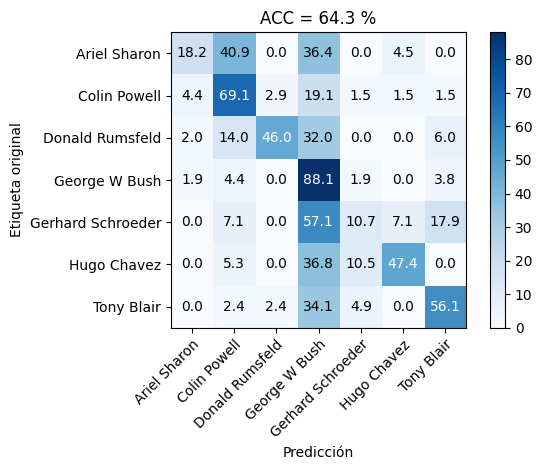

                   precision    recall  f1-score   support

     Ariel Sharon       0.36      0.18      0.24        22
     Colin Powell       0.64      0.69      0.66        68
  Donald Rumsfeld       0.88      0.46      0.61        50
    George W Bush       0.65      0.88      0.75       159
Gerhard Schroeder       0.27      0.11      0.15        28
      Hugo Chavez       0.69      0.47      0.56        19
       Tony Blair       0.61      0.56      0.58        41

         accuracy                           0.64       387
        macro avg       0.59      0.48      0.51       387
     weighted avg       0.63      0.64      0.62       387

Evaluating model 6/8


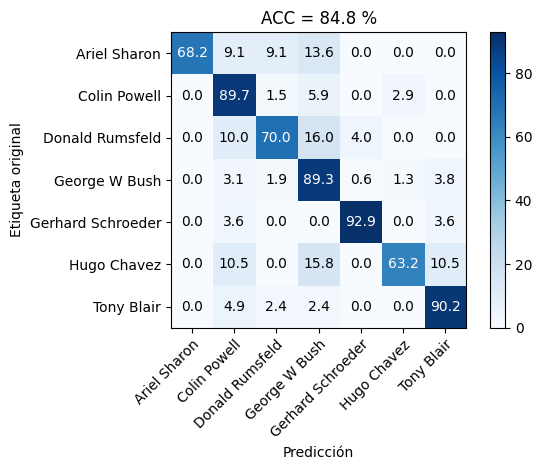

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.68      0.81        22
     Colin Powell       0.78      0.90      0.84        68
  Donald Rumsfeld       0.83      0.70      0.76        50
    George W Bush       0.88      0.89      0.89       159
Gerhard Schroeder       0.90      0.93      0.91        28
      Hugo Chavez       0.75      0.63      0.69        19
       Tony Blair       0.80      0.90      0.85        41

         accuracy                           0.85       387
        macro avg       0.85      0.80      0.82       387
     weighted avg       0.85      0.85      0.85       387

Evaluating model 7/8


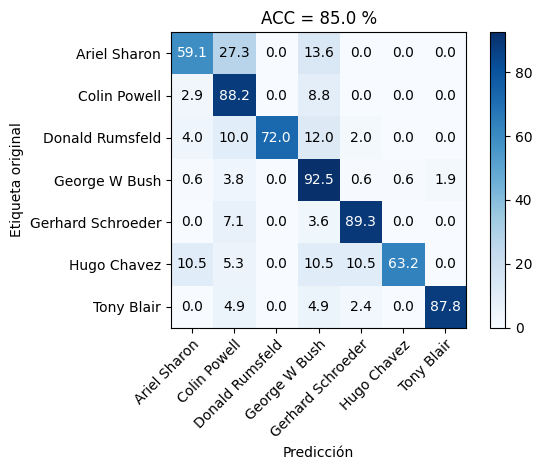

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387

Evaluating model 8/8


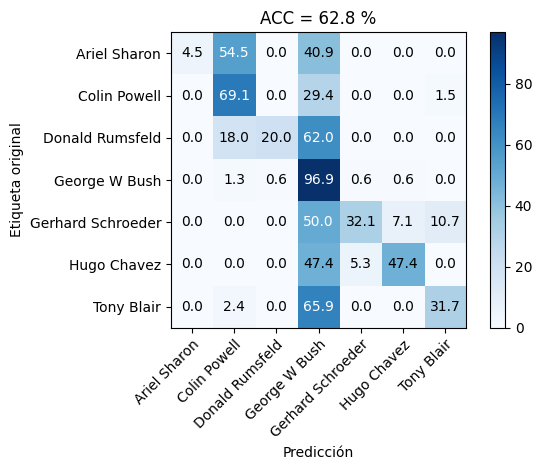

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.05      0.09        22
     Colin Powell       0.66      0.69      0.68        68
  Donald Rumsfeld       0.91      0.20      0.33        50
    George W Bush       0.58      0.97      0.73       159
Gerhard Schroeder       0.82      0.32      0.46        28
      Hugo Chavez       0.75      0.47      0.58        19
       Tony Blair       0.76      0.32      0.45        41

         accuracy                           0.63       387
        macro avg       0.78      0.43      0.47       387
     weighted avg       0.71      0.63      0.57       387



In [ ]:
# Se evalua el Accuracy pra los modelos ajustados con gridsearch
for i in range(len(models_acc)):
    if i < len(label_models):
        print('Evaluating model %s (%d/%d)' % (label_models[i], i + 1, len(models_acc)))

        ytest_e = models_acc[i].best_estimator_.predict(Xtest)
        acc = accuracy_score(ytest, ytest_e)

        plot_confusion_matrix(
            ytest, ytest_e,
            classes=lfw_people.target_names,
            normalize=True,
            title='ACC = %.1f %%' % (100 * acc)
        )
        plt.autoscale()
        # save_fig(path_img,label_models[i])
        plt.show()

        cr = classification_report(
            ytest, ytest_e,
            labels=range(lfw_people.target_names.shape[0]),
            target_names=lfw_people.target_names
        )
        # support = #muestras en la clase estudiada
        print(cr)
    else:
        print(f"Evaluating model {i+1}/{len(models_acc)}") #

        ytest_e = models_acc[i].best_estimator_.predict(Xtest)
        acc = accuracy_score(ytest, ytest_e)

        plot_confusion_matrix(
            ytest, ytest_e,
            classes=lfw_people.target_names,
            normalize=True,
            title='ACC = %.1f %%' % (100 * acc)
        )
        plt.autoscale()
        plt.show()

        cr = classification_report(
            ytest, ytest_e,
            labels=range(lfw_people.target_names.shape[0]),
            target_names=lfw_people.target_names
        )
        print(cr)

In [ ]:
parameters = [{
              'cla__var_smoothing': [1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline 1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline 2 - hyperparametros
              'cla__loss': ['hinge', 'log', 'modified_huber'],
              'cla__penalty': ['l1', 'l2', 'elasticnet']
              },
              {
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline 3 - hyperparametros
              },
              {
              'cla__solver': ['svd', 'lsqr', 'eigen'],#Pipeline 4 - hyperparametros
              },
              {
              'cla__n_neighbors': [3,5,7,9,11,13,15,17,19,21],#Pipeline 5 - hyperparametros
              'cla__weights': ['uniform', 'distance'],
              'cla__metric': ['euclidean', 'manhattan', 'minkowski']
              },
              {
              'cla__C': [1,10,1e2,1e3,1e4],#Pipeline 6 - hyperparametros
              'cla__loss': ['squared_hinge'],
              'cla__penalty': ['l2']
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline 7 - hyperparametros
             },
              {
              'cla__n_estimators': [20,50], #Pipeline 8 - hyperparametros
              'cla__criterion': ['gini', 'entropy'],
              'cla__max_depth': [3,5,7,9,11],
              'cla__min_samples_split': [2,4,6],
              'cla__min_samples_leaf': [1,3,5]
              }
             ]
#Modelos con scoring = f1
models_f1 = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='f1',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    #joblib.dump(models,filename+".pkl")

modelo 1/8
Fitting 5 folds for each of 13 candidates, totalling 65 fits
modelo 2/8
Fitting 5 folds for each of 63 candidates, totalling 315 fits
modelo 3/8
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 4/8
Fitting 5 folds for each of 3 candidates, totalling 15 fits
modelo 5/8
Fitting 5 folds for each of 60 candidates, totalling 300 fits
modelo 6/8
Fitting 5 folds for each of 5 candidates, totalling 25 fits
modelo 7/8
Fitting 5 folds for each of 25 candidates, totalling 125 fits
modelo 8/8
Fitting 5 folds for each of 180 candidates, totalling 900 fits


Evaluating model MinMax_Logistic (1/8)
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        22
     Colin Powell       0.59      0.32      0.42        68
  Donald Rumsfeld       0.00      0.00      0.00        50
    George W Bush       0.45      0.98      0.62       159
Gerhard Schroeder       0.00      0.00      0.00        28
      Hugo Chavez       0.00      0.00      0.00        19
       Tony Blair       1.00      0.05      0.09        41

         accuracy                           0.47       387
        macro avg       0.29      0.19      0.16       387
     weighted avg       0.40      0.47      0.34       387

Evaluating model MinMax_SGD (2/8)
                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.50      0.58        22
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.79      0.68      0.73        50
    George W Bush       0.88      0.91

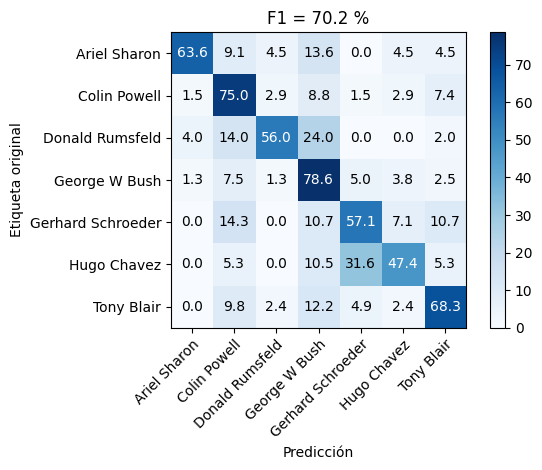

                   precision    recall  f1-score   support

     Ariel Sharon       0.74      0.64      0.68        22
     Colin Powell       0.63      0.75      0.68        68
  Donald Rumsfeld       0.82      0.56      0.67        50
    George W Bush       0.80      0.79      0.79       159
Gerhard Schroeder       0.48      0.57      0.52        28
      Hugo Chavez       0.43      0.47      0.45        19
       Tony Blair       0.65      0.68      0.67        41

         accuracy                           0.70       387
        macro avg       0.65      0.64      0.64       387
     weighted avg       0.71      0.70      0.70       387

Evaluating model 5/8


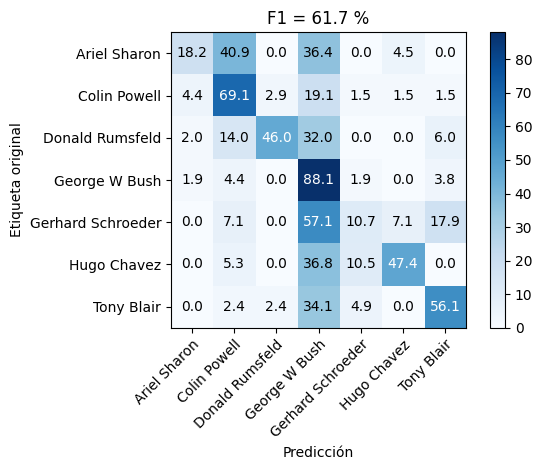

                   precision    recall  f1-score   support

     Ariel Sharon       0.36      0.18      0.24        22
     Colin Powell       0.64      0.69      0.66        68
  Donald Rumsfeld       0.88      0.46      0.61        50
    George W Bush       0.65      0.88      0.75       159
Gerhard Schroeder       0.27      0.11      0.15        28
      Hugo Chavez       0.69      0.47      0.56        19
       Tony Blair       0.61      0.56      0.58        41

         accuracy                           0.64       387
        macro avg       0.59      0.48      0.51       387
     weighted avg       0.63      0.64      0.62       387

Evaluating model 6/8


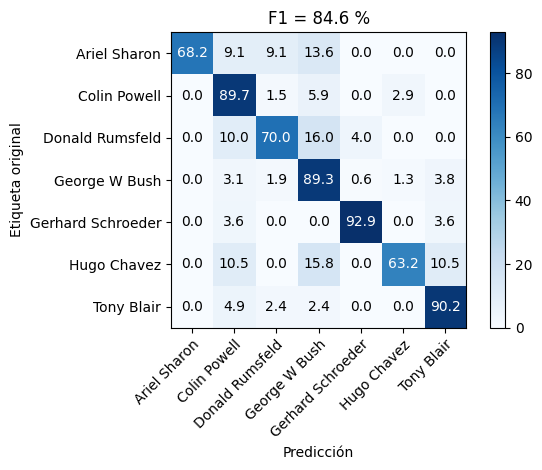

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.68      0.81        22
     Colin Powell       0.78      0.90      0.84        68
  Donald Rumsfeld       0.83      0.70      0.76        50
    George W Bush       0.88      0.89      0.89       159
Gerhard Schroeder       0.90      0.93      0.91        28
      Hugo Chavez       0.75      0.63      0.69        19
       Tony Blair       0.80      0.90      0.85        41

         accuracy                           0.85       387
        macro avg       0.85      0.80      0.82       387
     weighted avg       0.85      0.85      0.85       387

Evaluating model 7/8


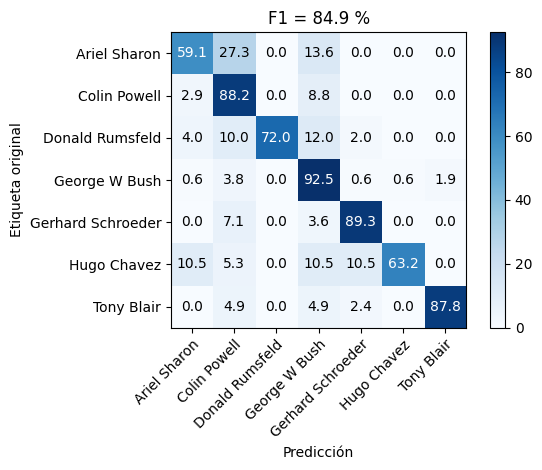

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387

Evaluating model 8/8


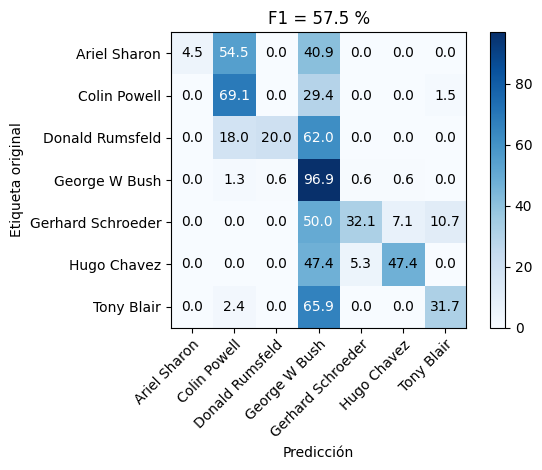

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.05      0.09        22
     Colin Powell       0.66      0.69      0.68        68
  Donald Rumsfeld       0.91      0.20      0.33        50
    George W Bush       0.58      0.97      0.73       159
Gerhard Schroeder       0.82      0.32      0.46        28
      Hugo Chavez       0.75      0.47      0.58        19
       Tony Blair       0.76      0.32      0.45        41

         accuracy                           0.63       387
        macro avg       0.78      0.43      0.47       387
     weighted avg       0.71      0.63      0.57       387



In [ ]:
from sklearn.metrics import f1_score, classification_report# import the necessary functions

# Se evalúa el F1 score para los modelos ajustados con gridsearch
for i in range(len(models_acc)):
    if i < len(label_models):
        print('Evaluating model %s (%d/%d)' % (label_models[i], i + 1, len(models_acc)))

        # Predicción del modelo sobre los datos de prueba
        ytest_e = models_acc[i].best_estimator_.predict(Xtest)

        # Cálculo del F1 score (en lugar de Accuracy)
        f1 = f1_score(ytest, ytest_e, average='weighted')  # 'weighted' toma en cuenta el desbalance de clases

        # Mostrar matriz de confusión
        # plot_confusion_matrix(
        #     ytest, ytest_e,
        #     classes=lfw_people.target_names,
        #     normalize=True,
        #     title='F1 = %.1f %%' % (100 * f1)
        # )
        # plt.autoscale()
        # plt.show()

        # Reporte de clasificación detallado
        cr = classification_report(
            ytest, ytest_e,
            labels=range(lfw_people.target_names.shape[0]),
            target_names=lfw_people.target_names
        )
        print(cr)

    else:
        print(f"Evaluating model {i+1}/{len(models_acc)}")

        # Predicción del modelo sobre los datos de prueba
        ytest_e = models_acc[i].best_estimator_.predict(Xtest)

        # Cálculo del F1 score (en lugar de Accuracy)
        f1 = f1_score(ytest, ytest_e, average='weighted')

        # Mostrar matriz de confusión
        plot_confusion_matrix(
            ytest, ytest_e,
            classes=lfw_people.target_names,
            normalize=True,
            title='F1 = %.1f %%' % (100 * f1)
        )
        plt.autoscale()
        plt.show()

        # Reporte de clasificación detallado
        cr = classification_report(
            ytest, ytest_e,
            labels=range(lfw_people.target_names.shape[0]),
            target_names=lfw_people.target_names
        )
        print(cr)